## Import Resources

In [77]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
import tf_keras
from tensorflow.keras.regularizers import l2


In [78]:

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_set, validation_set, test_set = dataset['train'], dataset['validation'], dataset['test']

def normalize_and_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    return image, label

## Explore the Dataset

In [79]:
num_train = dataset_info.splits['train'].num_examples
num_val = dataset_info.splits['validation'].num_examples
num_test = dataset_info.splits['test'].num_examples
print(f'Training samples: {num_train}, Validation samples: {num_val}, Test samples: {num_test}')

num_classes = dataset_info.features['label'].num_classes
print(f'Number of classes: {num_classes}')


Training samples: 1020, Validation samples: 1020, Test samples: 6149
Number of classes: 102


In [80]:
for image, label in train_set.take(3):
    print(f'Image shape: {image.shape}, Label: {label.numpy()}')


Image shape: (500, 667, 3), Label: 72
Image shape: (500, 666, 3), Label: 84
Image shape: (670, 500, 3), Label: 70


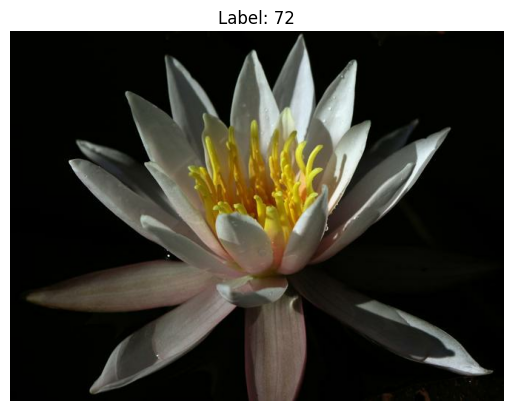

In [81]:
for image, label in train_set.take(1):
    plt.imshow(image)
    plt.title(f'Label: {label.numpy()}')
    plt.axis('off')
    plt.show()

In [82]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

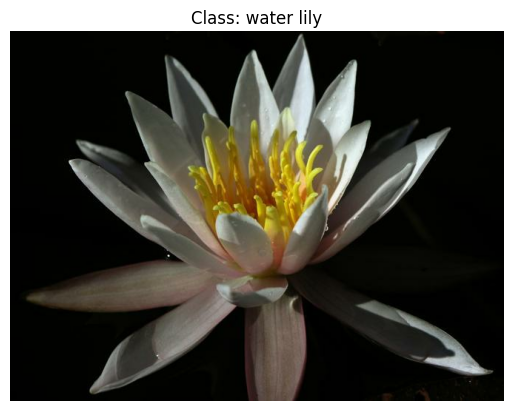

In [83]:
class_names = dataset_info.features['label'].names
for image, label in train_set.take(1):
    plt.imshow(image)
    plt.title(f'Class: {class_names[label.numpy()]}')
    plt.axis('off')
    plt.show()


## Create Pipeline

In [84]:
BATCH_SIZE = 32
train_batches = (train_set
                 .shuffle(1000)
                 .map(normalize_and_resize)
                 .batch(BATCH_SIZE)
                 .prefetch(1))

validation_batches = (validation_set
                     .map(normalize_and_resize)
                     .batch(BATCH_SIZE)
                     .prefetch(1))

test_batches = (test_set
                .map(normalize_and_resize)
                .batch(BATCH_SIZE)
                .prefetch(1))


In [85]:

model = tf_keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/2",
                   trainable=False),
    tf_keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    tf_keras.layers.Dropout(0.3),
    tf_keras.layers.Dense(102, activation='softmax')
])

model.build([None, 224, 224, 3])

model.compile(
    optimizer=tf_keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [86]:

NUM_EPOCHS = 30
history = model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    validation_data=validation_batches
)


Epoch 1/30
32/32 [==============================] - 11s 119ms/step - loss: 5.5023 - accuracy: 0.0196 - val_loss: 5.2049 - val_accuracy: 0.0373
Epoch 2/30
32/32 [==============================] - 6s 98ms/step - loss: 5.0201 - accuracy: 0.0784 - val_loss: 4.8877 - val_accuracy: 0.1206
Epoch 3/30
32/32 [==============================] - 5s 100ms/step - loss: 4.5809 - accuracy: 0.1804 - val_loss: 4.5738 - val_accuracy: 0.2480
Epoch 4/30
32/32 [==============================] - 6s 143ms/step - loss: 4.1885 - accuracy: 0.3039 - val_loss: 4.2458 - val_accuracy: 0.3382
Epoch 5/30
32/32 [==============================] - 5s 121ms/step - loss: 3.7893 - accuracy: 0.4235 - val_loss: 3.9062 - val_accuracy: 0.4363
Epoch 6/30
32/32 [==============================] - 5s 99ms/step - loss: 3.3554 - accuracy: 0.5363 - val_loss: 3.5806 - val_accuracy: 0.5255
Epoch 7/30
32/32 [==============================] - 6s 143ms/step - loss: 3.0368 - accuracy: 0.5912 - val_loss: 3.2944 - val_accuracy: 0.5676
Epoch 8

In [87]:
model.save('flower_classifier_model.h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.11/dist-packages/tf_keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'keras.src.regularizers.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


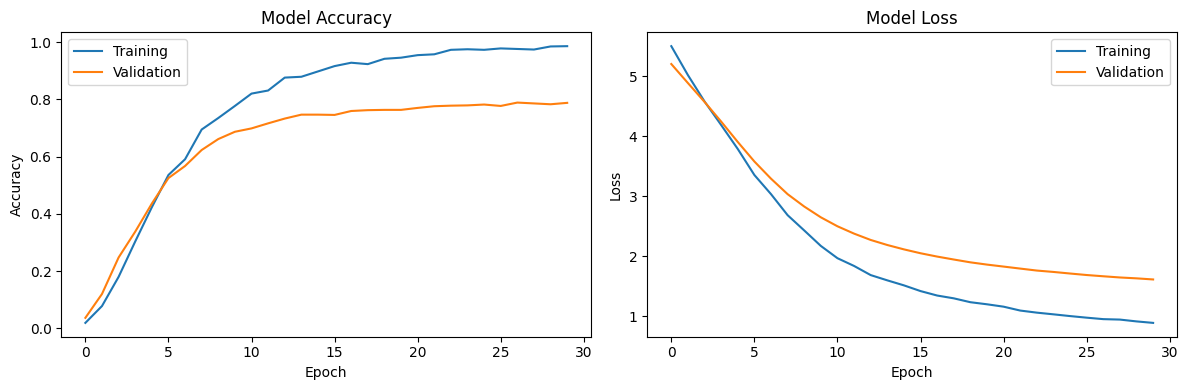

In [88]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [89]:

model.save('flower_classifier_model.h5')


In [90]:
my_reloaded_model = tf_keras.models.load_model(
       ('flower_classifier_model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [91]:

def process_image(image):

    image = tf.convert_to_tensor(image)

    image = tf.image.resize(image, (224, 224))

    image = image / 255.0
    return image.numpy()


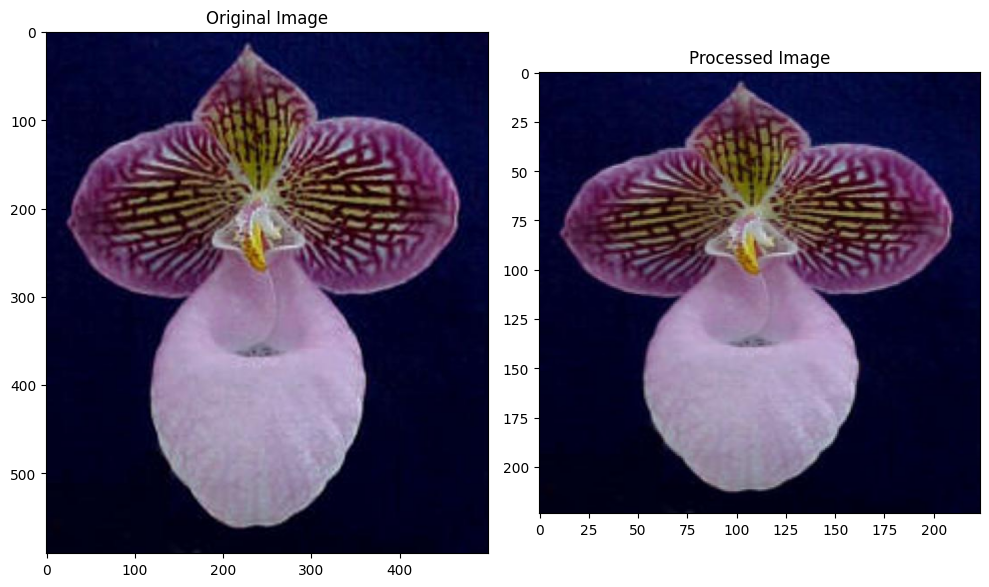

In [92]:
from PIL import Image

image_path = './hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [93]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


193/193 [==============================] - 13s 69ms/step - loss: 1.7439 - accuracy: 0.7613

Test accuracy: 0.7613
Test loss: 1.7439


In [94]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

for images, labels in test_batches:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

1/1 [==============================] - 0s 483ms/step


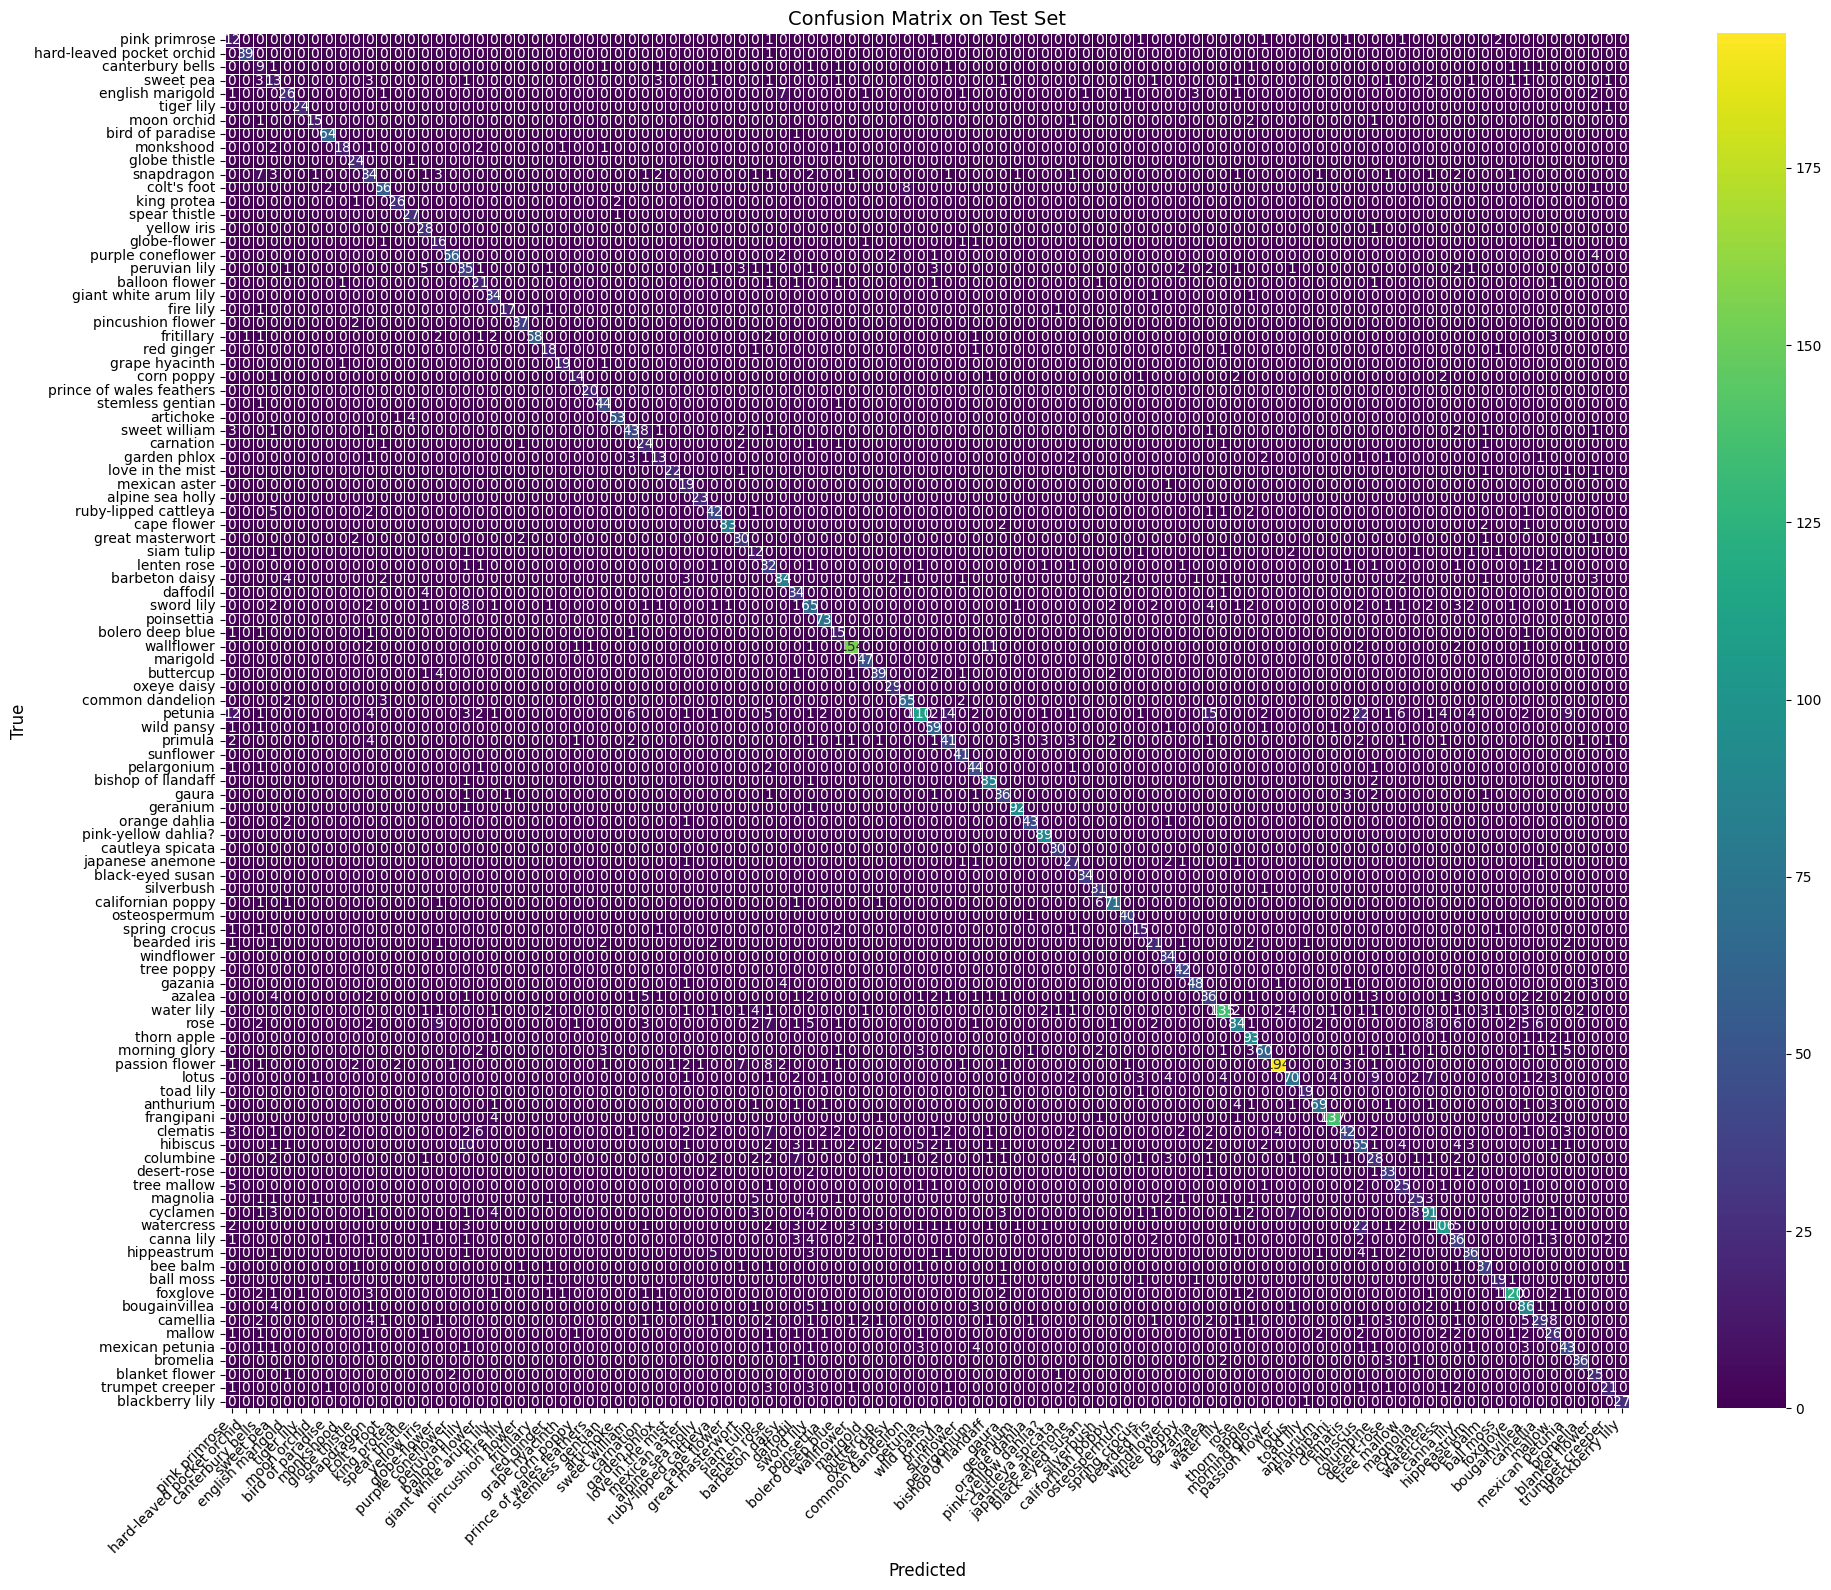

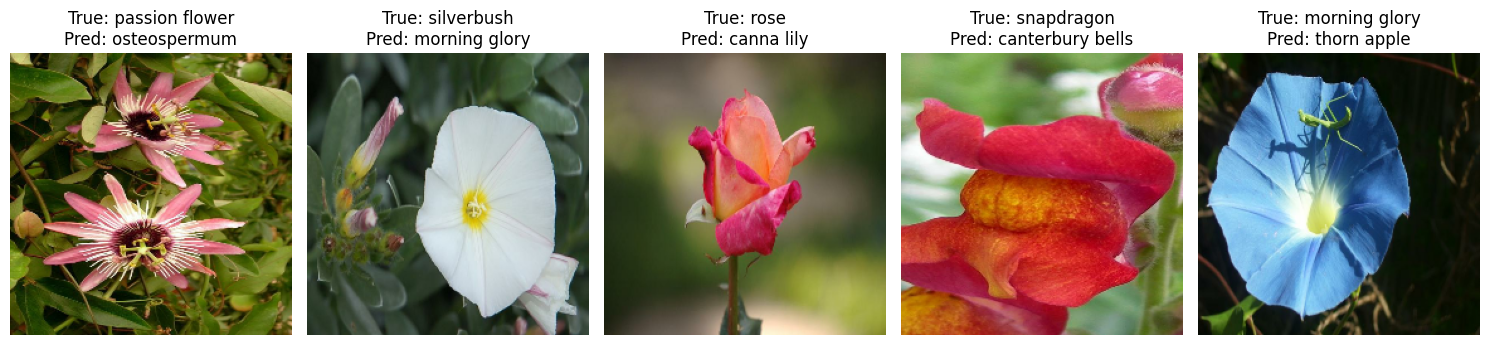

In [95]:
plt.figure(figsize=(20, 16))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='viridis',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 10},
    linewidths=0.5
    )

plt.title('Confusion Matrix on Test Set', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

misclassified_indices = np.where(np.array(y_pred) != np.array(y_true))[0]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:5]):
    plt.subplot(1, 5, i+1)
    for images, labels in test_batches:
        if idx < len(images):
            plt.imshow(images[idx])
            plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}')
            plt.axis('off')
            break
plt.tight_layout()
plt.show()

In [96]:

def predict(image_path, model, top_k=5):
    im = Image.open(image_path)
    image = np.asarray(im)
    processed_image = process_image(image)

    expanded_image = np.expand_dims(processed_image, axis=0)

    predictions = model.predict(expanded_image)

    top_k_values, top_k_indices = tf.nn.top_k(predictions[0], k=top_k)

    return top_k_values.numpy(), top_k_indices.numpy()


In [97]:
def plot_prediction(image_path, probs, classes, class_names):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    flower_names = [class_names[str(i)] for i in classes]
    plt.barh(np.arange(len(probs)), probs)
    plt.yticks(np.arange(len(probs)), flower_names)
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')

    plt.tight_layout()
    plt.show()


Predicting for image: ./hard-leaved_pocket_orchid.jpg
1/1 [==============================] - 0s 30ms/step
Top 5 Predictions:
hard-leaved pocket orchid: 0.9854
spring crocus: 0.0020
moon orchid: 0.0019
tiger lily: 0.0014
anthurium: 0.0012


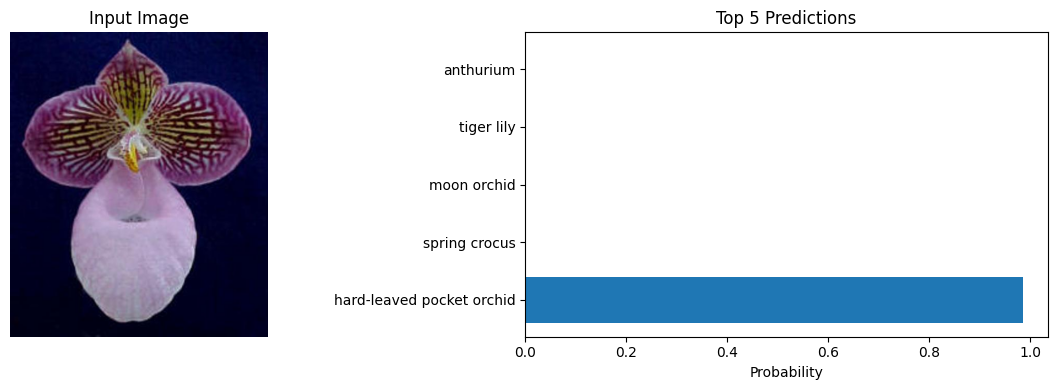

In [98]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

test_images = [
    './hard-leaved_pocket_orchid.jpg',
]

for image_path in test_images:
    print(f"\nPredicting for image: {image_path}")

    probs, classes = predict(image_path, model, top_k=5)

    print("Top 5 Predictions:")
    for prob, cls in zip(probs, classes):
        flower_name = class_names[str(cls)]
        print(f"{flower_name}: {prob:.4f}")

    plot_prediction(image_path, probs, classes, class_names)